# 3. Stressmodels
In this notebook you will learn:
- what a response function is
- what the parameters of a response function are.
- what the results of a time series model are.
- how response functions and external stressed are combined in a stressmodel.
- how stressmodels are used in a time series model.
- how a time series model is solved.

### Contents
1. [response function](#response)
2. [external stress](#stress)
3. [stressmodel](#stressmodel)
4. [time series model](#tsa)
5. [optimization](#optimization)

In [1]:
# importeer de benodigde packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pastas as ps
%matplotlib inline

### 1. response function<a name="response"></a>
Pastas has a diverse set of predefined response functions. Every response function tries to mimic the response of the groundwater levels to an external stress. In [this notebook](2_external_stresses.ipynb) we already used different response functions for different stresses. In this notebook we will go into more depth and start by examining the `Gamma` response function. This is the default response function for precipitation and evaporation in pastas. The function has three parameters (`A`, `n` & `a`). We can get the block response when we specify the 3 parameters of the `Gamma` function, in this case we use three pretty random values `4, 2 and 6`.

In [2]:
rfunc = ps.Gamma()
block_response = rfunc.block(p=[4, 2, 6])

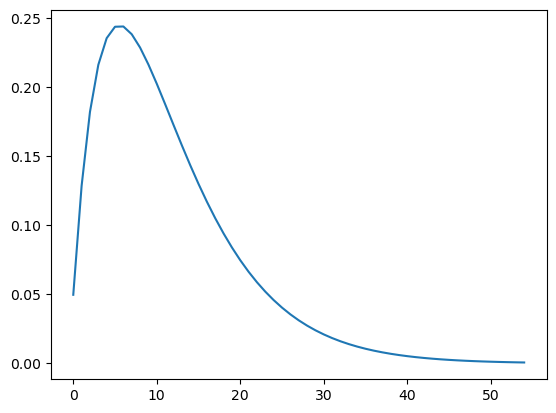

In [3]:
plt.plot(block_response)

#### Exercise 1 <a name="ex1"></a>
Use 3 different sets of parameters to create different response function. Plot them in the same figure. Make sure that all parameters are nonzero, positive numbers.

<a href="#ans1">Answer Exercise 1</a>

### 2. External stress<a name="stress"></a>

We can use the response function together with a time series of an external stress to mimick groundwater levels. To explain this in more detail we create an artifcial stress series. The stress is always 0 except at the 5th of january where it is 1.

2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    1.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
Freq: D, dtype: float64

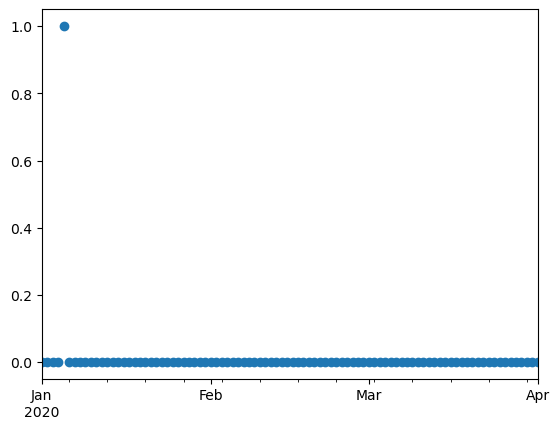

In [4]:
dates = pd.date_range('2020-1-1', '2020-4-1')
art_stress = pd.Series(index = dates, data=np.zeros(len(dates)))
art_stress.loc['2020-1-5'] = 1.0
art_stress.plot(ls='', marker='o')
art_stress.head(10)

### 3. Stressmodel<a name="stressmodel"></a>

We combine the articifical stress series and the response function in a stressmodel. 

In [6]:
stressmodel = ps.StressModel(art_stress, ps.Gamma(), name='artificial_response')

Now we can use the `stressmodel` to `simulate` the effect of this particular stress. We use the same parameters for the response function as we did before (`4`, `2` & `6`).

In [7]:
def plot_sim_with_stress(simulated_series, stress):
    
    ax = simulated_series.plot(label='simulated effect', color='orange')
    ax2 = ax.twinx()
    stress.plot(ax=ax2, marker='o', ls='', label='stress')

    ax.set_ylabel('effect')
    ax.legend(loc=6)

    ax2.set_ylabel('stress')
    ax2.legend(loc=5)

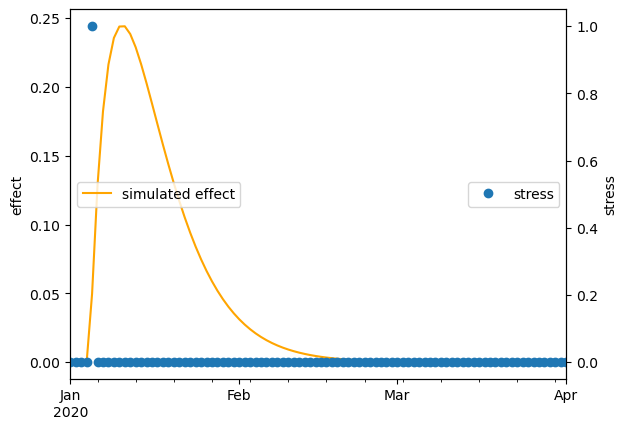

In [8]:
simulated_series = stressmodel.simulate(p=[4, 2, 6])
plot_sim_with_stress(simulated_series, art_stress)

In the figure above you can see that the simulated effect has the exact same shape as the block response function in [chapter 1](#response). When we modify our stress series it becomes more clear how the stress series and the response function are combined to simulate the effect of the stress. The simulated effect is calculated using a mathematical operation called [convolution](https://en.wikipedia.org/wiki/Convolution).

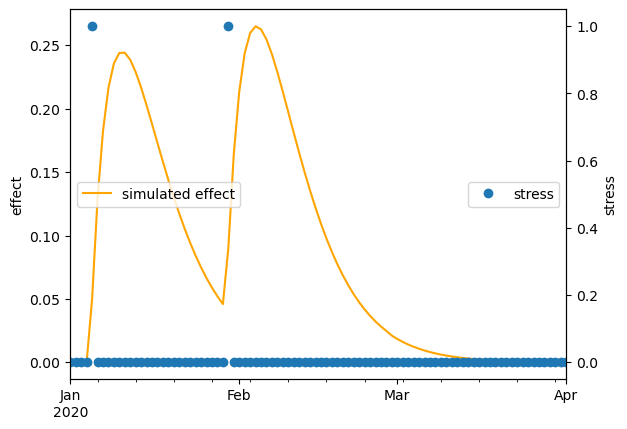

In [10]:
art_stress.loc['2020-1-30'] = 1.0
stressmodel = ps.StressModel(art_stress, ps.Gamma(), name='artificial_response')
simulated_series = stressmodel.simulate(p=[4, 2, 6])
plot_sim_with_stress(simulated_series, art_stress)

#### Exercise 2<a name="ex2"></a>

Use the different parameter sets from exercise 2 to simulate the effect of the external stress. Visualise your results.

<a href="#ans2">Answer Exercise 2</a>

In the figure below we used a random artificial stress to simulate the effect. Now the simulated effect start to look more like real measurements.

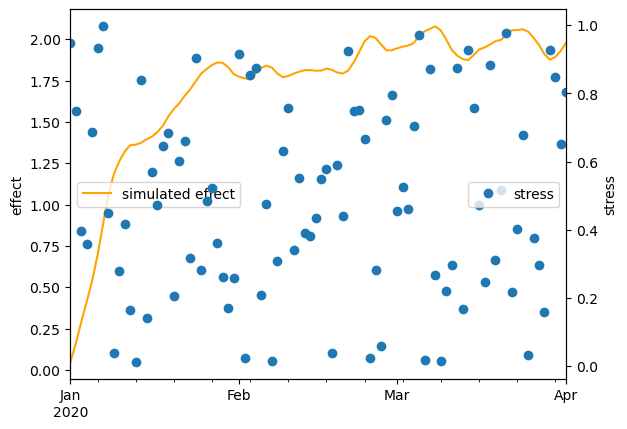

In [19]:
dates = pd.date_range('2020-1-1', '2020-4-1')
art_stress = pd.Series(index = dates, data=np.random.random(len(dates)))
stressmodel = ps.StressModel(art_stress, ps.Gamma(), name='artificial_response', settings='prec')
simulated_series = stressmodel.simulate(p=[4, 2, 6])
plot_sim_with_stress(simulated_series, art_stress)

### 4. time series model parameters<a name="tsa"></a>

The next step is to try and fit the simulated effect on an observed effect. Instead of using real observations we generate a time series with "observed" values, let's say they represent groundwater heads. In the code cell below we use the `simulated_series` from the previous chapter and add a small error to create observed values.

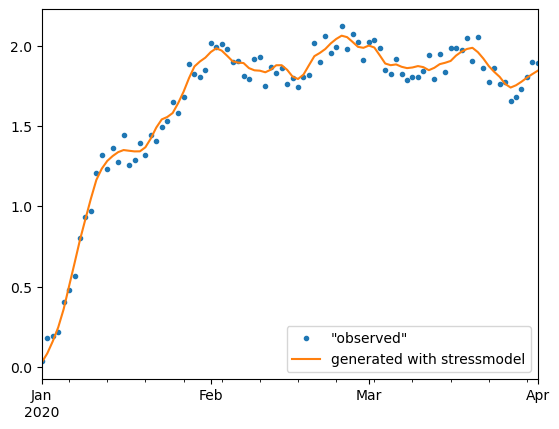

In [15]:
random_error = pd.Series(index = dates, data=(np.random.random(len(dates))-0.5)/5)
oseries = simulated_series + random_error
oseries.plot(label='"observed"', ls='', marker='.')
simulated_series.plot(label='generated with stressmodel')
plt.legend()

**create time series model**<br>
In the code cell below we create a time series model using our "observed" groundwater heads (`oseries`). Then we add the `stressmodel` to this time series model. Finally we simulate and visualise groundwater heads using our time series model.

INFO: Time Series 'None' was extended in the past to 2010-01-03 00:00:00 with the mean value (0.49) of the time series.


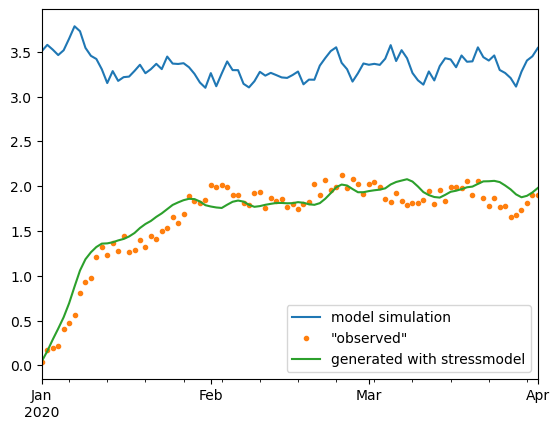

In [20]:
# create time series model
ml = ps.Model(oseries)
ml.add_stressmodel(stressmodel)

# simulate groundwater heads
model_sim = ml.simulate()

#visualise results
model_sim.plot(label='model simulation')
oseries.plot(label='"observed"', ls='', marker='.')
simulated_series.plot(label='generated with stressmodel')
plt.legend()

We can see that the model simulation does not correspond with the "observed" groundwater heads or the ones generated with the stressmodel. You may have noticed that when we called `ml.simulate()` we did not specify any parameters like we did with `stressmodel.simulate()`. When you do not specify parameters for `ml.simulate()` default values are used. In this case the `initial` parameter values are used because the model isn't solved yet. The parameter values are listed in the `ml.parameters` dataframe.

In [21]:
ml.parameters

,initial,name,optimal,pmin,pmax,vary,stderr,dist
artificial_response_A,3.461814,artificial_response,NaN,0.00001,346.181381,True,NaN,uniform
artificial_response_n,1.000000,artificial_response,NaN,0.01000,100.000000,True,NaN,uniform
artificial_response_a,10.000000,artificial_response,NaN,0.01000,10000.000000,True,NaN,uniform
constant_d,1.648925,constant,NaN,NaN,NaN,True,NaN,uniform
noise_alpha,1.000000,noise,NaN,0.00001,5000.000000,True,NaN,uniform


#### Exercise 3 <a name="ex3"></a>

You can also call `ml.simulate()` with a specific parameter set. Call `ml.simulate` with the initial parameter set. Visualise the results like the figure above and check that the results are the same.

<a href="#ans3">Answer Exercise 3</a>

The parameter dataframe (`ml.parameters`) lists the 5 parameters of our time series model: `artificial_response_A, artificial_response_n, artificial_response_a`, `constant_d` and `noise_alpha`. Three parameters from the stressmodel and 2 from the time series model.

When we solve the model with `ml.solve()` these parameters are varied until an optimal fit is found between observed and simulated groundwater heads.

#### Exercise 4 <a name="ex4"></a>

Solve the model. What happens to the parameter values in `ml.parameters`? 

<a href="#ans4">Answer Exercise 4</a>

#### Exercise 5 <a name="ex5"></a>

Simulate the groundwater levels again like you did in exercise 3. Use the solved model from exercise 4. 

<a href="#ans5">Answer Exercise 5</a>

#### Exercise 6 <a name="ex6"></a>

Simulate the groundwater levels using the optimal parameter values except for `constant_d`. For `constant_d` you use the value `1.0`.

Visualise the results together with the simulated values from exercise 5. What do you think is the use of the `constant_d` parameter?

<a href="#ans5">Answer Exercise 6</a>

### 5. optimization<a name="optimization"></a>
When calling `ml.solve()` the parameters of the time series model are optimised by fitting the simulated groundwater levels on the observerd groundwater levels. Below we use the `TrackSolve` method from pastas to visualise the steps taken by the optimisation algorithm.

In [ ]:
from pastas.plots import TrackSolve
%matplotlib notebook
track = TrackSolve(ml)
track.initialize_figure()
ml.solve(callback=track.plot_track_solve)

### 6. Model results<a name="modelresults"></a>

When the `ml.solve()` function is called a report is printed with the results of the optimization. This report has 4 sections:
- Model Results Observations
- Fit statistics
- Parameters
- Parameter correlations

**Model Results Observations**<br>
This section contains the following information:
- `nfev`: the number of function evaluations. This is the number of model simulations executed by the optimisation algorithm before the optimal parameter values were found.
- `nobs`: the number of observations that were used to fit the model simulation on. In our case this is the number of values in `oseries`.
- `noise`: parameter indicating if a noise model was used during the optimisation. A noisemodel can be used to obtain statistical information of the time series model.
- `tmin` and `tmax`: the start and end date of the observation. By default this is the start and end date of the `oseries`.
- `freq`: the frequency of the time series model. In this case `D` stands for Daily. This means that observed and simulated groundwater levels are compared on a daily basis.
- `warmup`: the warmup period used for the model. The groundwater heads on a certain date depend on the external stresses over a period before this date. We don't know the length of this period. Therefore an arbitrary period of 10 years is used to get a proper simulation of the groundwater head on the start date of the observations. We call this the warmup period. If the external stresses during the warmup period are unknown the average values are used in this period.
- `solver`: The optimisation algorithm used to fit simulated and observed groundwater levels.

**Fit statistics**<br>
These statistics give information about the fit between simulated and observed groundwater heads. The abbreveations mean the following:
- `EVP`: Explained variance also known as the Nash Sutcliffe coëficient. A value of 100% represents an optimal fit. Many people use a fit higher than 60-80% to accept or reject the results of the model.
- `R2`: the R squared value of the fit. A value of 1 represents an optimal fit.
- `RMSE`: the root mean squared error. A value of 0 represents an optimal fit. 
- `AIC`: the Aikake Information Criterion 
- `BIC`: the Bayesan Information Criterion 

**Parameters**<br>
This section shows the optimal parameter values that were found with the optimisation algorithm. Besides the optimal value also the standard deviation `stderr` and the initial parameter values are shown. The `vary` column shows if the parameter value was optimised with the algorithm.

**Parameter correlations**<br>
This section shows the correlation between parameters. Only correlations with an absolute value of rho higher than 0.5 are shown. A correlation between two parameters close to 1 or -1 appears when similar model results can be obtained with a different set of the two parameters.

In [ ]:
%matplotlib inline 
ml.solve()

#### Exercise 7 <a name="ex7"></a>

Use the files `groundwater.csv`, `rain.csv`, `evaporation.csv` and `waterlevel` to build a time series model, with the following external stresses:
- recharge using `Stressmodel2` and the `Gamma` response function.
- waterlevel using `Stressmodel` and the `Exponential` response function.

solve the model using `noise=False` and look at the printed report. How many parameters does the `Exponential` response function have?

<a href="#ans7">Answer Exercise 7</a>

#### Exercise 8 <a name="ex8"></a>

Plot the results of the model from exercise 7 using the `plots` submodule. Is the groundwater response to groundwater recharge faster than the response to fluctuations in waterlevels or the other way around? What does the absolute value of the response tell you?

<a href="#ans8">Answer Exercise 8</a>

In [ ]:
ml.solve()


## Answers

#### <a href="#ex1">Answer exercise 1</a> <a name="ans1"></a>

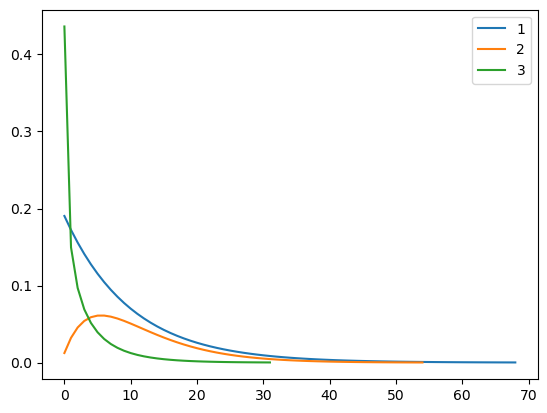

In [11]:
block_response1 = rfunc.block(p=[2, 1, 10])
block_response2 = rfunc.block(p=[1, 2, 6])
block_response3 = rfunc.block(p=[1, 0.5, 6])
plt.plot(block_response1, label='1')
plt.plot(block_response2, label='2')
plt.plot(block_response3, label='3')
plt.legend()

#### <a href="#ex2">Answer exercise 2</a> <a name="ans2"></a>

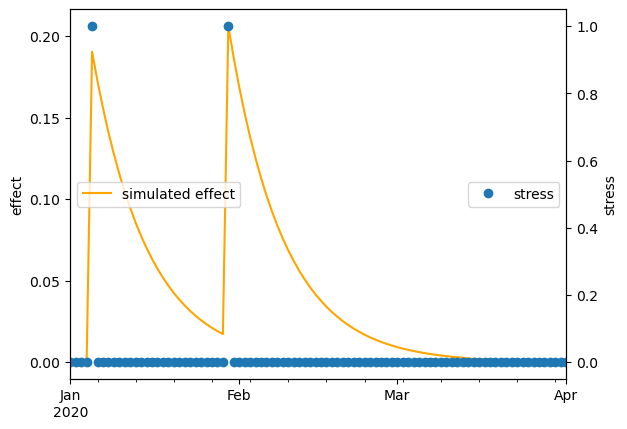

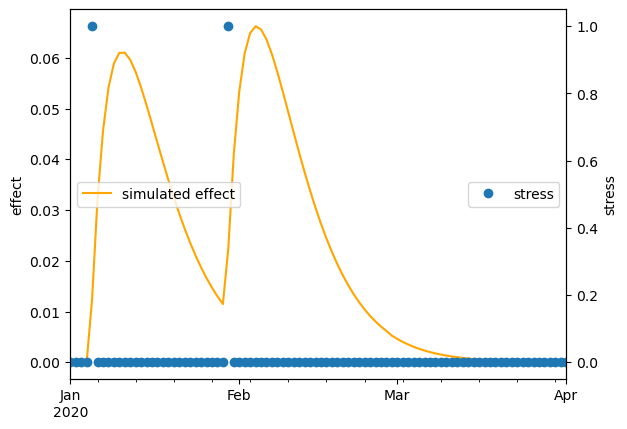

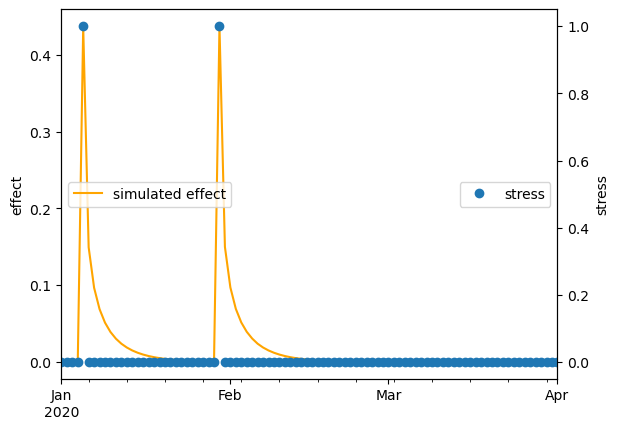

In [12]:
simulated_series1 = stressmodel.simulate(p=[2, 1, 10])
simulated_series2 = stressmodel.simulate(p=[1, 2, 6])
simulated_series3 = stressmodel.simulate(p=[1, 0.5, 6])
plt.figure()
plot_sim_with_stress(simulated_series1, art_stress)
plt.figure()
plot_sim_with_stress(simulated_series2, art_stress)
plt.figure()
plot_sim_with_stress(simulated_series3, art_stress)

#### <a href="#ex3">Answer exercise 3</a> <a name="ans3"></a>

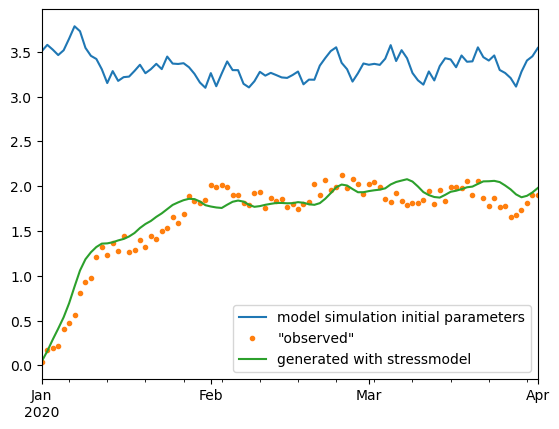

In [22]:
ini_param = ml.parameters['initial'].values
sim_ini_param = ml.simulate(p=ini_param)

#visualise results
sim_ini_param.plot(label='model simulation initial parameters')
oseries.plot(label='"observed"', ls='', marker='.')
simulated_series.plot(label='generated with stressmodel')
plt.legend()

#### <a href="#ex4">Answer exercise 4</a> <a name="ans4"></a>

You can see that the `optimal` parameter values were found with the `solve` method. Before these values were all NaN. You may also notice that the `optimal` parameter values of the stressmodel (`A, n and a`) are fairly similar to the values (`4,2 and 6`) that we used to create our "observed" groundwater heads.

In [28]:
ml.solve(report=False, noise=False)
ml.parameters

,initial,name,optimal,pmin,pmax,vary,stderr,dist
artificial_response_A,3.461814,artificial_response,295.149799,0.00001,346.181381,True,117569.114692,uniform
artificial_response_n,1.000000,artificial_response,99.999999,0.01000,100.000000,True,14990.965974,uniform
artificial_response_a,10.000000,artificial_response,29.786773,0.01000,10000.000000,True,3600.839044,uniform
constant_d,1.648925,constant,-142.488851,NaN,NaN,True,58081.482766,uniform


#### <a href="#ex5">Answer exercise 5</a> <a name="ans5"></a>

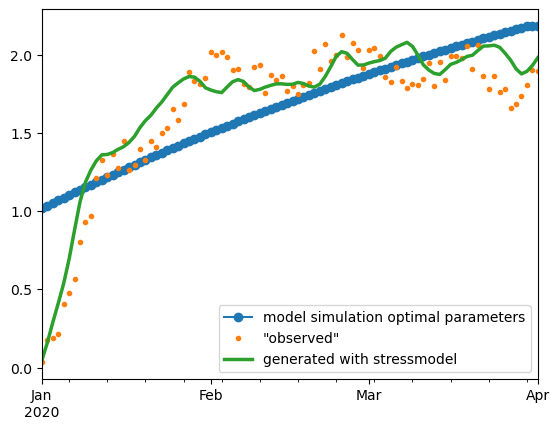

In [29]:
# simulate groundwater head with optimized parameters
opt_param = ml.parameters['optimal'].values
sim_opt_param = ml.simulate(p=opt_param)

# or simply use
sim_opt_param = ml.simulate()

#visualise results
sim_opt_param.plot(label='model simulation optimal parameters', marker='o')
oseries.plot(label='"observed"', ls='', marker='.')
simulated_series.plot(lw=2.5, label='generated with stressmodel')
plt.legend()

#### <a href="#ex6">Answer exercise 6</a> <a name="ans6"></a>

The `constant_d` parameter is the reference level. In our model the groundwater levels are simulated using the reference level + the effect of the stressmodel.

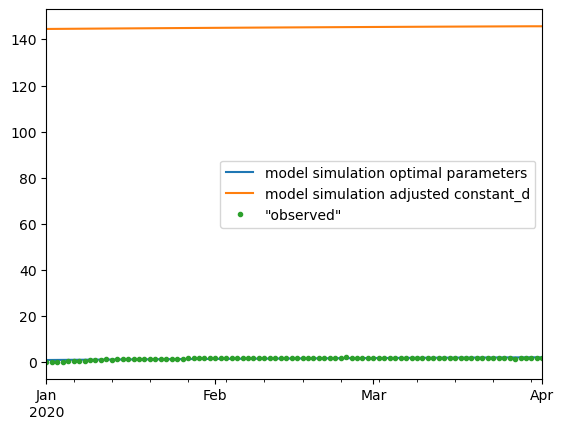

In [31]:
# simulate groundwater head with optimized parameters
opt_param = ml.parameters['optimal'].values

semi_opt_param = opt_param.copy()
semi_opt_param[3] = 1.0


sim_opt_param = ml.simulate(p=opt_param)
sim_semi_opt = ml.simulate(p=semi_opt_param)

#visualise results
sim_opt_param.plot(label='model simulation optimal parameters')
sim_semi_opt.plot(label='model simulation adjusted constant_d')
oseries.plot(label='"observed"', ls='', marker='.')
plt.legend()

#### <a href="#ex7">Answer exercise 7</a> <a name="ans7"></a>

The exponential function has two parameters.

In [34]:
oseries1 = pd.read_csv("data/nb2/groundwater.csv",
                       parse_dates=True, index_col=0)
rain1 = pd.read_csv("data/nb2/rain.csv", parse_dates=True,
                    index_col=0)
evap1 = pd.read_csv("data/nb2/evap.csv", parse_dates=True,
                    dayfirst=True, index_col=0)

waterlevel = pd.read_csv("data/nb2/waterlevel.csv",
                         parse_dates=True, index_col=0)

ml1 = ps.Model(oseries1)
sm1 = ps.RechargeModel(rain1, evap1, rfunc=ps.Gamma(), name="recharge")
ml1.add_stressmodel(sm1)

ml1.parameters

# normalize
waterlevel = waterlevel - waterlevel.mean()

w = ps.StressModel(waterlevel, rfunc=ps.Exponential(),
                   name="waterlevel", settings="waterlevel")

ml1.add_stressmodel(w)
ml1.solve(noise=False)

C:\Users\oebbe\AppData\Local\Temp\ipykernel_13500\2558521912.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  evap1 = pd.read_csv("data/nb2/evap.csv", parse_dates=True,
INFO: 1D-DataFrame was provided, automatically transformed to pandas.Series.
INFO: 1D-DataFrame was provided, automatically transformed to pandas.Series.
INFO: 1D-DataFrame was provided, automatically transformed to pandas.Series.
INFO: 1D-DataFrame was provided, automatically transformed to pandas.Series.
INFO: Time Series 'Precipitation' was extended in the past to 2000-01-04 00:00:00 with the mean value (0.002) of the time series.
INFO: Time Series 'Evaporation' was extended in the past to 2000-01-04 00:00:00 with the mean value (0.0016) of the time series.
INFO: Time Series ' Waterlevel' was extended in the past to 2000-01-04 00:00:00 with the mean value (-1.3e-15) of the tim

Fit report head                     Fit Statistics
nfev    33                     EVP           87.06
nobs    3015                   R2             0.87
noise   False                  RMSE           0.10
tmin    2010-01-01 00:00:00    AIC       -13591.38
tmax    2018-04-05 00:00:00    BIC       -13549.30
freq    D                      Obj           16.54
warmup  3650 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (7 optimized)
                 optimal  stderr     initial  vary
recharge_A    218.717490  ±3.92%  208.540395  True
recharge_n      1.021801  ±2.58%    1.000000  True
recharge_a     99.940727  ±6.14%   10.000000  True
recharge_f     -1.346280  ±3.03%   -1.000000  True
waterlevel_A    0.392658  ±1.42%    2.547063  True
waterlevel_a    1.592417  ±6.17%   10.000000  True
constant_d      8.876536  ±0.16%    8.863658  True


#### <a href="#ex8">Answer exercise 8</a> <a name="ans8"></a>

With `ml.plots.results()` you can plot the results of the time series model including the response functions. You can see there that the values of the respones function to recharge are more or less 100x larger than the values of the response function to waterlevel fluctuations. This makes sense when you keep in mind that 10 mm of precipitation will lead to a bigger rise in grondwater levels than 10 mm of waterlevel rise in a nearby river.

[<Axes: xlabel='date'>,
 <Axes: xlabel='date'>,
 <Axes: title={'right': "Stresses: ['Precipitation', 'Evaporation']"}>,
 <Axes: title={'center': 'Step response'}, xlabel='Time [days]'>,
 <Axes: title={'right': "Stresses: [' Waterlevel']"}>,
 <Axes: title={'center': 'Step response'}, xlabel='Time [days]'>,
 <Axes: title={'left': 'Model Parameters ($n_c$=7)'}>]

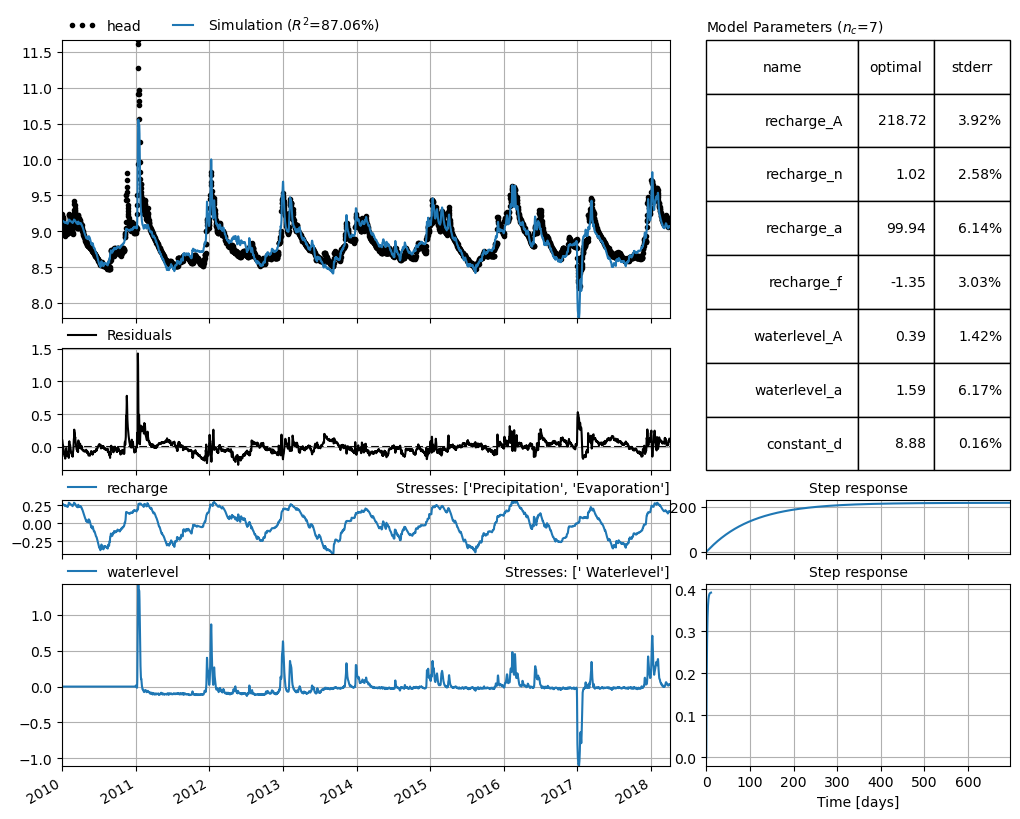

In [35]:
ml1.plots.results()